In [56]:
#numeric: pandas and numpy
import numpy as np
import pandas as pd
import seaborn as sns

# graphics
%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 

from sklearn import linear_model, svm
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score,zero_one_loss

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from mlxtend.evaluate import mcnemar

## Read Data

In [36]:
name_features = []
with open('sensors-19-05524-s001/sensors-19-05524-s001_new/labels.txt', 'r') as file:
    content = file.read()
    cols = content.split('\n')
   # print(cols)
    name_features = cols[1:-2]   # remove first column and the last two
    
Y = []
X = []

with open('sensors-19-05524-s001/sensors-19-05524-s001_new/data.txt', 'r') as file:
    content = file.read()
    cols = content.split('\n')
    for c in cols[:-1]:
        data = c.split(',')
        X.append(data[1:-1])
        Y.append(data[-1])
        
# Convert String to Float
X = np.array(X).astype(float)
print(type(X[0][0]))

#Convert String to Int
Y = np.array(Y).astype(int)
print(type(Y[0]))
    
print(f"Features: {len(X[0])}")
print(f"Records in DB: {len(X)}")
print(f"Size Y: {len(Y)}")

<class 'numpy.float64'>
<class 'numpy.int64'>
Features: 533
Records in DB: 4480
Size Y: 4480


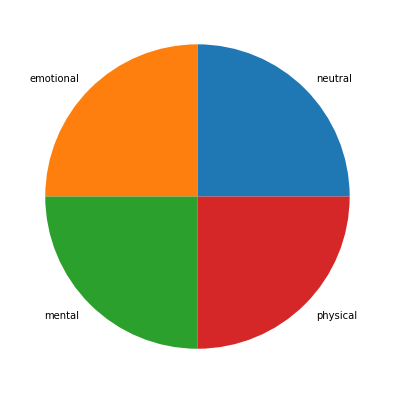

In [37]:
labels = list(range(1,5))
quantity = [np.sum(Y == label) for label in labels]

# Creating plot 
fig = plt.figure(figsize =(10, 7)) 
plt.pie(quantity, labels=["neutral", "emotional", "mental", "physical"]) 
  
# show plot 
plt.show()

## Feature Selection


### Pearson's Correlation Matrix
Primeiro nós usamos a matriz de correlacao de Pearson para filtrar features que fossem bastante correlacionadas com outras, pois, ao analisar o dataset, vimos que varias provinham de calculos a partir de outros valores, por exemplo médias, medianas, desvios-padrão, etc. Logo, esperamos que esta matriz irá tirar features que são redundantes para os modelos de machine learning poderem treinar com um vetores menores.

In [38]:
data_features = pd.DataFrame(X, dtype='float')

corr_matrix = data_features.corr().abs()

In [39]:
def drop_features(ds, corr, threshold=0.8):
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return ds.drop(ds[to_drop], axis=1)

reduced_dataset = drop_features(data_features, corr_matrix)
reduced_dataset.head()

,0,1,4,5,8,11,13,14,15,18,...,445,447,448,451,454,456,485,488,489,495
0,-0.004125,0.254095,-0.538509,5.95534,-0.10937,-0.065212,0.001901,231.814,16.2733,0.374904,...,-4.85458,2.357070,9.48421,-15.5916,4.14944,-2.59232,16.0,798.68,0.63875,31.4247
1,0.031029,0.193761,0.781415,5.18794,-0.08737,-0.057924,0.002046,230.500,15.5536,0.397898,...,-6.90565,2.476570,11.24150,-16.9271,5.89258,-2.59483,20.0,798.68,0.68500,31.4359
2,0.015678,0.182336,0.881194,5.66530,-0.08037,-0.042190,0.002114,240.707,20.8210,0.725535,...,-5.94592,1.068740,4.24641,-14.9459,24.62180,-2.60259,24.0,798.68,0.68500,31.4478
3,0.014525,0.176636,1.024900,6.10968,-0.08037,-0.044888,0.002177,247.308,22.2275,0.267597,...,-6.18900,0.828304,4.28808,-14.6317,-28.60590,-2.61594,28.0,798.68,0.68375,31.4331
4,0.010349,0.179248,0.935697,5.83902,-0.08337,-0.041310,0.002217,247.744,20.1621,0.715390,...,-6.49062,0.988309,5.30232,-13.6923,-65.12220,-2.63103,32.0,798.68,0.71375,31.4347


In [40]:
X = reduced_dataset.to_numpy(dtype="float")
print(f"Features: {len(X[0])}")
print(f"Records in DB: {len(X)}")
print(f"Size Y: {len(Y)}")

Features: 103
Records in DB: 4480
Size Y: 4480


### Anova Ranking
Apesar de termos reduzido em bastante a dimensão do problema, tento retirado mais de 80% das features, treinar com vetores de 100 features ainda pode ser demasiado. Então, usando o método baseado em Anova Ranking, nós criamos vetores menores para diminuir a dimensão do problema

In [41]:
def get_best_x_features(df, dclass, num_features=50):

    df = (df - np.min(df))/(np.max(df) - np.min(df))
    
    k_bestfeatures = SelectKBest(score_func = f_classif)
    rankings = k_bestfeatures.fit(df, dclass)
    b=list(rankings.scores_)
    a=list(range(0,len(b)))

    sf = [g for _,g in sorted(zip(b,a))]
    sf=sf[len(a)-num_features:len(a)]
    sf=reversed(sf)
    inx=[]
    for chosen in sf:
        inx.append(chosen)
    
    dataset = pd.DataFrame(df, dtype='float')
    
    return dataset[inx].to_numpy(dtype='float')

In [42]:
X_50 = get_best_x_features(X,Y)
print(f"Features: {len(X_50[0])}")
print(f"Records in DB: {len(X_50)}")
print(f"Size Y: {len(Y)}")

Features: 50
Records in DB: 4480
Size Y: 4480


## Training Data

In [43]:
k_fold = StratifiedKFold(n_splits=4)

In [44]:
def processKFold(model, X, Y):
    
    scores = []
    train_loss = []
    loss = []
    
    for train_indexes, test_indexes in k_fold.split(X,Y):

        # normalize the data
        scaler = StandardScaler()

        X_train, X_test = X[train_indexes], X[test_indexes]
        Y_train, Y_test = Y[train_indexes], Y[test_indexes]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, Y_train)

        Y_pred = model.predict(X_test)

        Y_train_2 = model.predict(X_train)
        
        scores.append(accuracy_score(Y_test, Y_pred))
        loss.append(zero_one_loss(Y_test, Y_pred))
        train_loss.append(zero_one_loss(Y_train, Y_train_2))
        
    return np.mean(scores), np.mean(loss), np.mean(train_loss), Y_pred == Y_test

In [45]:
# Multilayer feedforward neural network

# change number after
def mlp8(X, Y):
    
    ppnML = MLPClassifier(hidden_layer_sizes=(8), activation="relu", solver='sgd', 
                          learning_rate='adaptive', max_iter=1100, random_state=1, learning_rate_init=0.01)

    return processKFold(ppnML, X, Y)

In [46]:
def mlp12(X, Y):
    
    ppnML = MLPClassifier(hidden_layer_sizes=(12), activation="relu", solver='sgd', 
                          learning_rate='adaptive', max_iter=1100, random_state=1, learning_rate_init=0.01)

    return processKFold(ppnML, X, Y)

In [47]:
def mlp16(X, Y):
    
    ppnML = MLPClassifier(hidden_layer_sizes=(16), activation="relu", solver='sgd', 
                          learning_rate='adaptive', max_iter=1300, random_state=1, learning_rate_init=0.01)

    return processKFold(ppnML, X, Y)

In [48]:
def mlp32(X, Y):
    
    ppnML = MLPClassifier(hidden_layer_sizes=(32), activation="relu", solver='sgd', 
                          learning_rate='adaptive', max_iter=1400, random_state=1, learning_rate_init=0.01)

    return processKFold(ppnML, X, Y)

In [49]:
# logistic regression
def lr(X, Y, my_C=1):
    
    lr = LogisticRegression(max_iter=600, C=my_C)
    
    return processKFold(lr, X, Y)

In [50]:
# svm rbf and svm linear 

def svmRBF(X, Y, c=1):

    svmRBF = svm.SVC(kernel='rbf', C = c)
    
    return processKFold(svmRBF, X, Y)

In [51]:

def svmRBFwGamma(X, Y, c=1, g=0.1):

    svmRBF = svm.SVC(kernel='rbf', C = c, gamma=g)
    
    return processKFold(svmRBF, X, Y)

In [52]:
def svmLinear(X, Y, c=1):

    svmLinear = svm.SVC(kernel='linear', C = c)
    
    return processKFold(svmLinear, X, Y)

In [53]:
def knn(X, Y, k=5, metric="minkowski"):
    
    knn_c = KNeighborsClassifier(n_neighbors=k, metric=metric)
     
    return processKFold(knn_c, X, Y)

# Tunning

## KNN

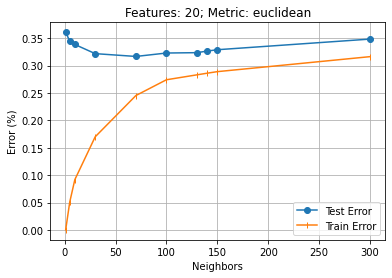

min: 0.31674107142857144
min neigh: 70


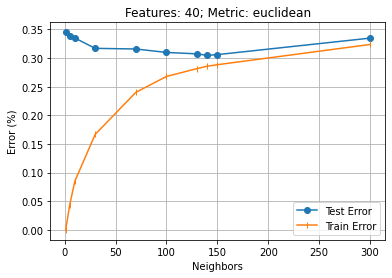

min: 0.3046875
min neigh: 140


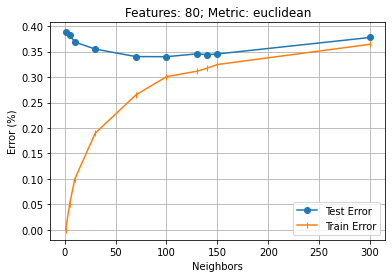

min: 0.3399553571428572
min neigh: 100


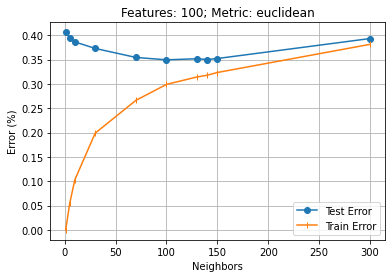

min: 0.34955357142857146
min neigh: 100


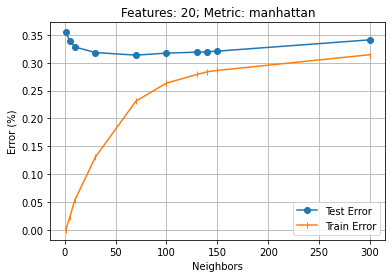

min: 0.3136160714285714
min neigh: 70


KeyboardInterrupt: 

In [16]:
# Teste Best k of neighbors
neighbors = [1, 5, 10, 30, 70, 100, 130, 140, 150, 300]
#neighbors = [130, 140, 141]

num_features = [40]
num_features = [20, 40 ,80, 100]
metrics_list = ["euclidean", "manhattan", "chebyshev", "minkowski"]

acc_knn = []
err_knn = []

train_loss = []

for m in metrics_list:
    for f in num_features:
        acc_knn = []
        err_knn = []
        train_loss = []
        for i in neighbors:

            X_new = get_best_x_features(X,Y, f)

            r = knn(X_new, Y, i, m)
            #print(r)
            acc_knn.append(r[0])
            err_knn.append(r[1])
            train_loss.append(r[2])


        plt.plot(neighbors, err_knn, marker="o" ,label="Test Error")
        plt.plot(neighbors, train_loss, marker="|" ,label="Train Error")

        plt.legend()
        plt.xlabel("Neighbors")
        plt.ylabel("Error (%)")
        plt.title("Features: " + str(f) + "; Metric: " + m )
        plt.grid()
        plt.show()
        print("min:", np.min(err_knn))
        print("min neigh:", neighbors[np.argmin(err_knn)])

## SVM Linear

In [ ]:

C_rgl = [0.01, 0.03, 0.1, 0.3, 1, 3]
num_features = [20, 40 ,80, 100]

acc_knn = []
err_knn = []

train_loss = []
for f in num_features:
    acc_knn = []
    err_knn = []
    train_loss = []
    for i in C_rgl:

        X_new = get_best_x_features(X,Y, f)

        r = svmLinear(X_new, Y, i)
        #print(r)
        acc_knn.append(r[0])
        err_knn.append(r[1])
        train_loss.append(r[2])
    
    plt.plot(C_rgl, err_knn, marker="o" ,label="Test Error")
    plt.plot(C_rgl, train_loss, marker="|" ,label="Train Error")
    
    plt.legend()
    plt.xlabel("C")
    plt.ylabel("Error (%)")
    plt.title(str(f))
    plt.grid()
    plt.show()
    print("min:", np.min(err_knn))
    print("min c:", C_rgl[np.argmin(err_knn)])

In [ ]:

C_rgl = [0.1, 0.3, 0.5, 0.8]
num_features = [20, 40 ,80, 100]

acc_knn = []
err_knn = []
plt.figure(figsize=(10,6))
train_loss = []
for f in num_features:
    acc_knn = []
    err_knn = []
    train_loss = []
    for i in C_rgl:

        X_new = get_best_x_features(X,Y, f)

        r = svmLinear(X_new, Y, i)
        #print(r)
        acc_knn.append(r[0])
        err_knn.append(r[1])
        train_loss.append(r[2])
    
    plt.plot(C_rgl, err_knn, marker="o" ,label="Test Error; Feats: " + str(f))
    plt.plot(C_rgl, train_loss, marker="|" ,label="Train Error; Feats: " + str(f))
    
    plt.legend()
    plt.xlabel("C")
    plt.ylabel("Error (%)")
    print("min:", np.min(err_knn))
    print("min c:", C_rgl[np.argmin(err_knn)])
plt.title("Linear SVM Error")
plt.grid()
plt.show()

## SVM RBF

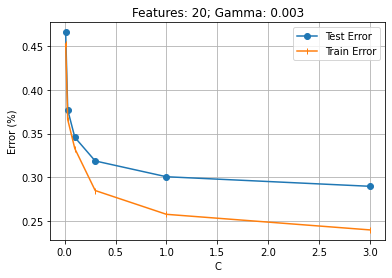

min: 0.2897321428571429
min c: 3


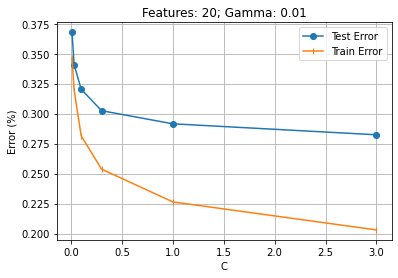

min: 0.2823660714285714
min c: 3


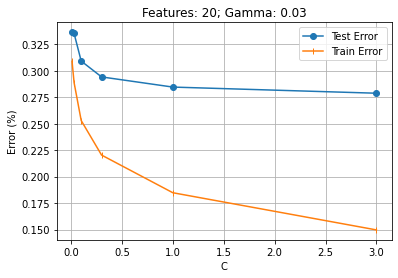

min: 0.27879464285714284
min c: 3


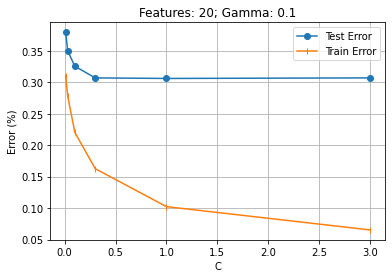

min: 0.30602678571428577
min c: 1


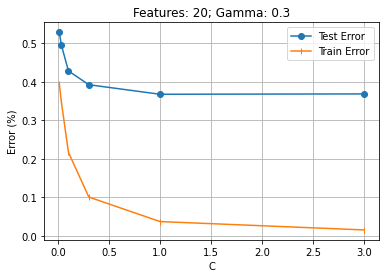

min: 0.3676339285714286
min c: 1


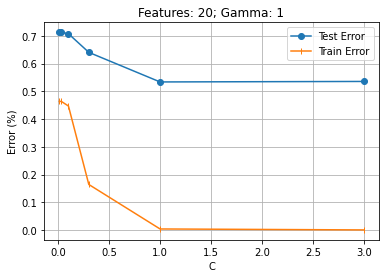

min: 0.5339285714285714
min c: 1


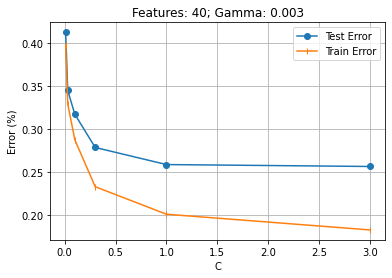

min: 0.2564732142857143
min c: 3


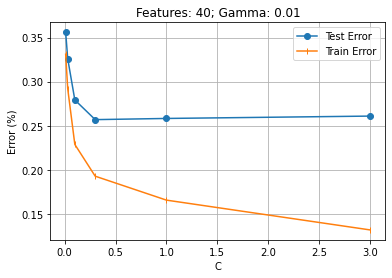

min: 0.25691964285714286
min c: 0.3


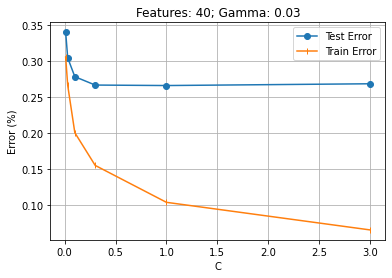

min: 0.2662946428571429
min c: 1


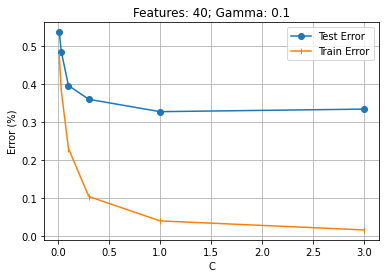

min: 0.3279017857142857
min c: 1


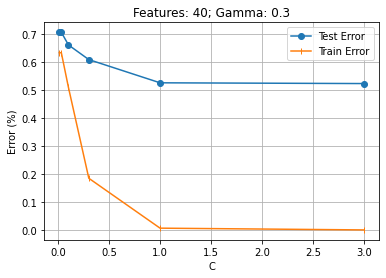

min: 0.5232142857142857
min c: 3


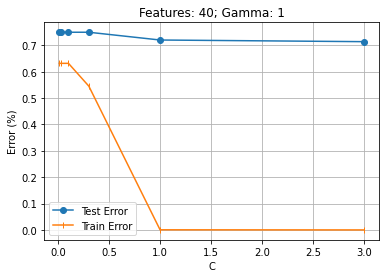

min: 0.7138392857142857
min c: 3


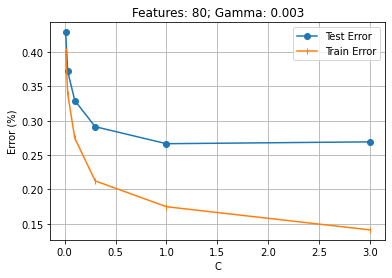

min: 0.26651785714285714
min c: 1


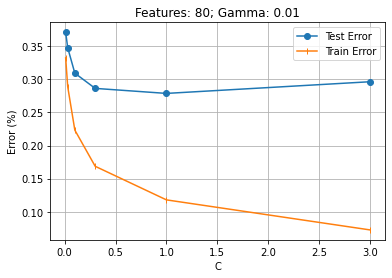

min: 0.27879464285714284
min c: 1


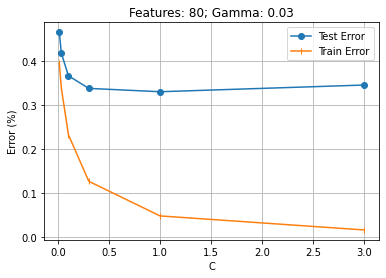

min: 0.33013392857142854
min c: 1


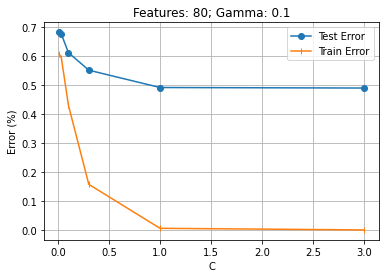

min: 0.490625
min c: 3


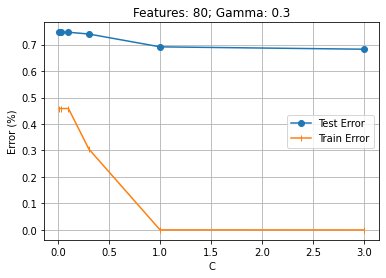

min: 0.6823660714285714
min c: 3


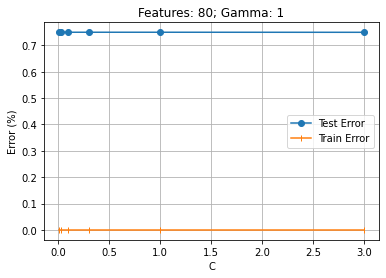

min: 0.7497767857142857
min c: 3


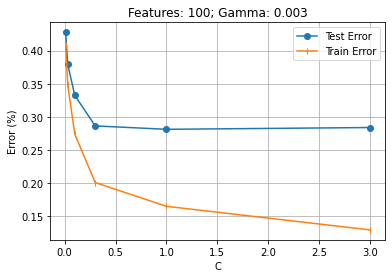

min: 0.28125
min c: 1


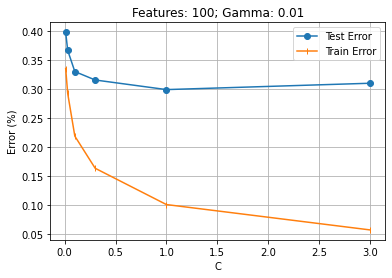

min: 0.2991071428571429
min c: 1


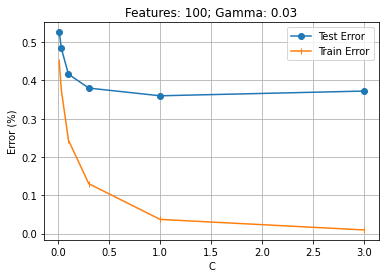

min: 0.3598214285714286
min c: 1


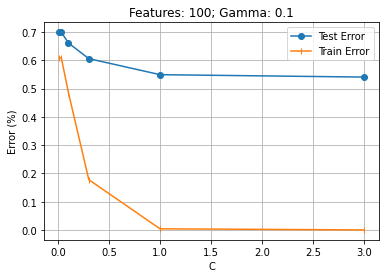

min: 0.5406249999999999
min c: 3


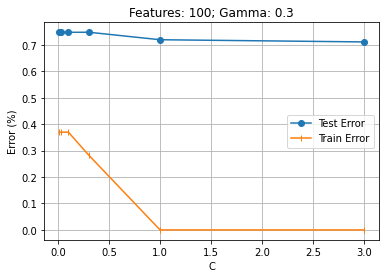

min: 0.7113839285714286
min c: 3


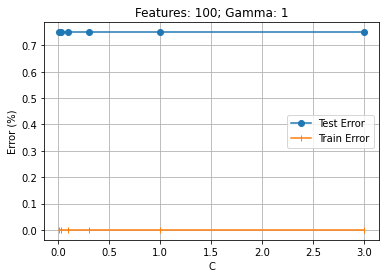

min: 0.75
min c: 0.01


In [32]:


C_rgl = [0.01, 0.03, 0.1, 0.3, 1, 3]
num_features = [20, 40 ,80, 100]
gammas = [0.003, 0.01, 0.03, 0.1, 0.3, 1]

acc_knn = []
err_knn = []

total_err_knn = []
total_err_train = []

train_loss = []
for f in num_features:
    for g in gammas:
        
        acc_knn = []
        err_knn = []
        train_loss = []
        for i in C_rgl:
    
            X_new = get_best_x_features(X,Y, f)
    
            r = svmRBFwGamma(X_new, Y, i, g)
            #print(r)
            acc_knn.append(r[0])
            err_knn.append(r[1])
            train_loss.append(r[2])
            
        total_err_knn.append(err_knn)
        total_err_train.append(train_loss)
        
        
        plt.plot(C_rgl, err_knn, marker="o" ,label="Test Error")
        plt.plot(C_rgl, train_loss, marker="|" ,label="Train Error")
        
        plt.legend()
        plt.xlabel("C")
        plt.ylabel("Error (%)")
        plt.title("Features: " + str(f) + "; Gamma: " + str(g))
        plt.grid()
        plt.show()
        print("min:", np.min(err_knn))
        print("min c:", C_rgl[np.argmin(err_knn)])

24
24


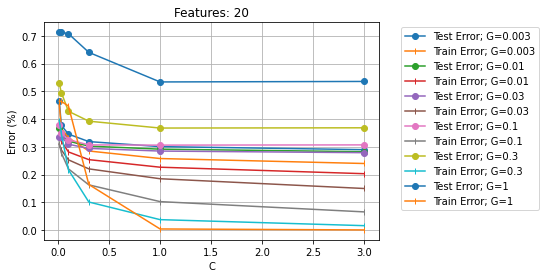

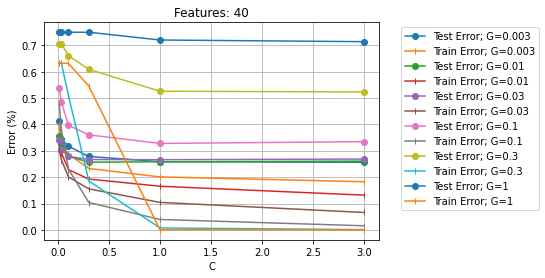

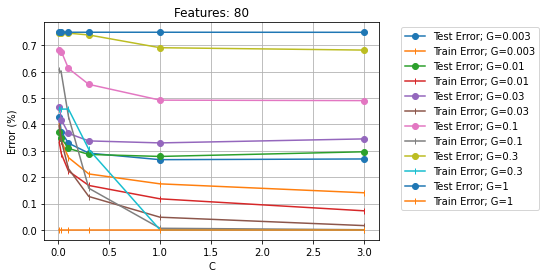

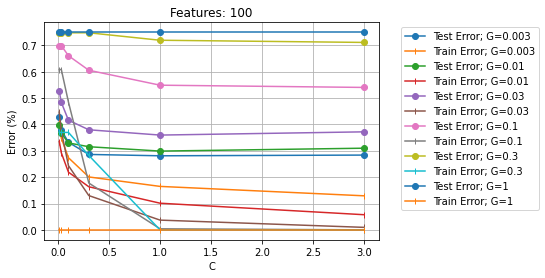

In [34]:
print(len(total_err_knn))
print(len(total_err_train))
for i in range(len(num_features)):
    for j in range(len(gammas)):
        #print(total_err_train[len(gammas) * i + j])
        plt.plot(C_rgl, total_err_knn[len(gammas) * i + j], marker="o" ,label="Test Error; G=" + str(gammas[j]))
        plt.plot(C_rgl, total_err_train[len(gammas) * i + j], marker="|" ,label="Train Error; G=" + str(gammas[j]))
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel("C")
        plt.ylabel("Error (%)")
        plt.title("Features: " + str(num_features[i]))
    plt.grid()
    plt.show()

### Variate number of features
In this section, we gonna variate the number of best features to trainning the model, to try to find the best number of features to get good results. 

In [57]:
num_features = [5, 20, 40 ,60, 80, 100]

loss_mpl8 = []
loss_mpl12 = []
loss_mpl16 = []
loss_mpl32 = []
loss_lr = []
loss_svm_rbf_gamma = []
loss_svm_linear = []
loss_svm_rbf = []
loss_knn = []

for num_feature in num_features:
    
    print(f"Number of features: {num_feature}")
    
    X_new = get_best_x_features(X,Y, num_feature)
    
    loss_mpl8.append(mlp8(X_new, Y)[1])
    loss_mpl12.append(mlp12(X_new, Y)[1])
    loss_mpl16.append(mlp16(X_new, Y)[1])
    loss_mpl32.append(mlp32(X_new, Y)[1])
    loss_svm_rbf.append(svmRBFwGamma(X_new, Y, c=0.3, g=0.03)[1])
    loss_svm_linear.append(svmLinear(X_new, Y)[1])
    loss_knn.append(knn(X_new, Y, 140)[1])
    loss_lr.append(lr(X_new, Y, 0.01)[1])

# convert to numpy array to be easily to convert values to percentage 
loss_mpl8 = np.array(loss_mpl8)
loss_mpl12 = np.array(loss_mpl12)
loss_mpl16 = np.array(loss_mpl16)
loss_mpl32 = np.array(loss_mpl32)
loss_svm_rbf = np.array(loss_svm_rbf)
loss_svm_linear = np.array(loss_svm_linear)
loss_knn = np.array(loss_knn)
loss_lr = np.array(loss_lr)


Number of features: 5
Number of features: 20
Number of features: 40
Number of features: 60
Number of features: 80
Number of features: 100


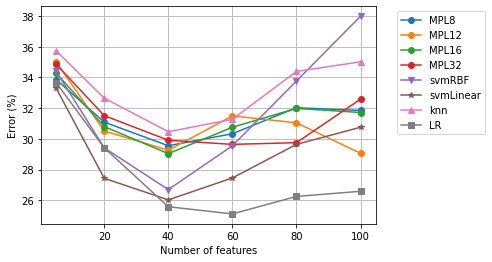

In [58]:
plt.plot(num_features, loss_mpl8 * 100, marker="o" ,label="MPL8")
plt.plot(num_features, loss_mpl12 * 100, marker="o" ,label="MPL12")
plt.plot(num_features, loss_mpl16 * 100, marker="o" ,label="MPL16")
plt.plot(num_features, loss_mpl32 * 100, marker="o" ,label="MPL32")
plt.plot(num_features, loss_svm_rbf * 100, marker="v", label="svmRBF")
plt.plot(num_features, loss_svm_linear * 100, marker="*" , label="svmLinear")
plt.plot(num_features, loss_knn * 100, marker="^" , label="knn")
plt.plot(num_features, loss_lr * 100, marker="s" , label="LR")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Number of features")
plt.ylabel("Error (%)")
plt.grid()

In [ ]:
# only for test
acc_mpl, loss_mpl, train, _ = mlp8(X, Y)

print(f"MPL:\nAcc: {acc_mpl}\nLoss: {loss_mpl}")

MPL:
Acc: 0.7194196428571429
Loss: 0.2805803571428571


In [ ]:
acc_svmRBF, loss_svmRBF,train,_ = svmRBF(X, Y)

print(f"svmRBF:\nAcc: {acc_svmRBF}\nLoss: {loss_svmRBF}")

svmRBF:
Acc: 0.7299107142857143
Loss: 0.2700892857142857


In [ ]:
acc_svmLinear, loss_svmLinear,train,_ = svmLinear(X, Y)

print(f"svmLinear:\nAcc: {acc_svmLinear}\nLoss: {loss_svmLinear}")

svmLinear:
Acc: 0.7417410714285715
Loss: 0.25825892857142857


# Comparison between Models

In [ ]:
def contingency_table(model1_correct, model2_correct):
    res = np.zeros((2,2))
    res[0,0] = np.sum(np.logical_and(model1_correct, model2_correct))
    res[0,1] = np.sum(np.logical_and(model1_correct, np.logical_not(model2_correct)))
    res[1,0] = np.sum(np.logical_and(np.logical_not(model1_correct), model2_correct))
    res[1,1] = np.sum(np.logical_and(np.logical_not(model1_correct), np.logical_not(model2_correct)))
    
    return res

In [ ]:
def conf_matrix(correct_values, model1_values):
    return confusion_matrix(correct_values, model1_values, normalize='true')

In [ ]:
def get_comparable_matrix(list_of_model_values, p_threshold=0.05):
    num_models = len(list_of_model_values)
    chi2_matrix = np.zeros((num_models, num_models))
    p_value_matrix = np.zeros((num_models, num_models))
    for i in range(num_models):
        for j in range(i, num_models):
            cont_table = contingency_table(list_of_model_values[i], list_of_model_values[j])
            chi2, p_value = mcnemar(ary=cont_table, corrected=True)
            chi2_matrix[i, j] = chi2
            chi2_matrix[j, i] = chi2
            p_value_matrix[i, j] = p_value
            p_value_matrix[j, i] = p_value
    print(p_value_matrix)
    print(chi2_matrix)
    print(p_value_matrix >= p_threshold)
    return chi2_matrix, p_value_matrix, p_value_matrix >= p_threshold

In [ ]:
# For test, lets compare the rbf, linear and mlp models
list_of_values = [
    mlp8(X, Y)[3],
    svmRBF(X, Y)[3],
    svmLinear(X, Y)[3],
]

In [ ]:
get_comparable_matrix(list_of_values)

[[670. 108.]
 [134. 208.]]
[[720.  58.]
 [158. 184.]]
[[769.  35.]
 [109. 207.]]
[[0.00000000e+00 1.08041017e-01 1.62697926e-11]
 [1.08041017e-01 0.00000000e+00 1.17709270e-09]
 [1.62697926e-11 1.17709270e-09 0.00000000e+00]]
[[ 0.          2.58264463 45.375     ]
 [ 2.58264463  0.         37.00694444]
 [45.375      37.00694444  0.        ]]
[[False  True False]
 [ True False False]
 [False False False]]


(array([[ 0.        ,  2.58264463, 45.375     ],
        [ 2.58264463,  0.        , 37.00694444],
        [45.375     , 37.00694444,  0.        ]]),
 array([[0.00000000e+00, 1.08041017e-01, 1.62697926e-11],
        [1.08041017e-01, 0.00000000e+00, 1.17709270e-09],
        [1.62697926e-11, 1.17709270e-09, 0.00000000e+00]]),
 array([[False,  True, False],
        [ True, False, False],
        [False, False, False]]))